## Initial numpyro installation

In [1]:
!pip install numpyro

     |████████████████████████████████| 283 kB 28.2 MB/s 


## Needed imports


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import time
from datetime import timedelta, date, datetime
from copy import deepcopy


# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## Read file with bitcoin prices in USD

In [34]:
df_price = pd.read_csv('/content/drive/MyDrive/model-based/BTC-USD.csv', parse_dates=True)

## See sample data in table

In [35]:
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


## Visualize the BTC price in time

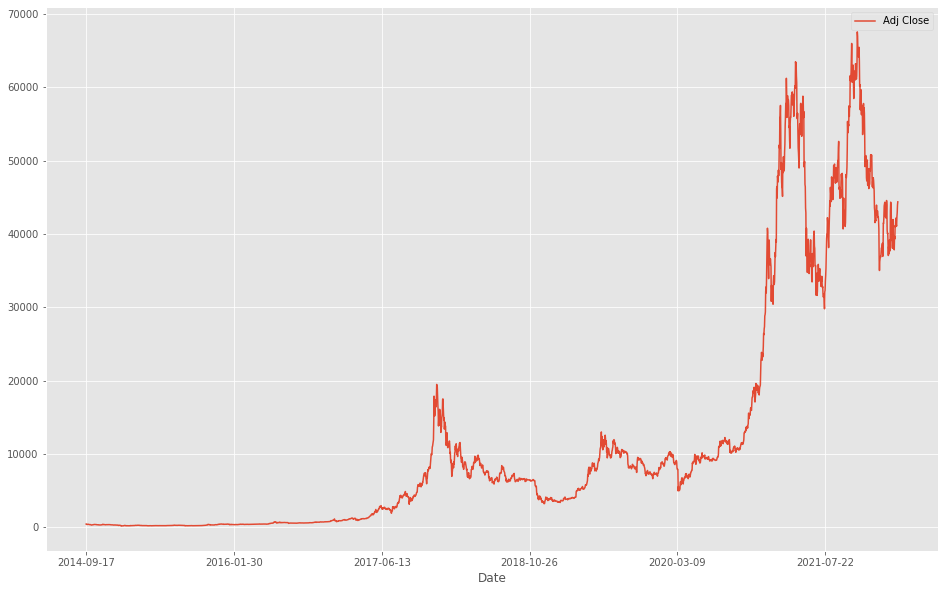

In [36]:
df_price.plot(x="Date", y="Adj Close")
plt.show()

## Load USD index data

In [37]:
df_usd = pd.read_csv('/content/drive/MyDrive/model-based/USD_historical_data.csv', parse_dates=True) 
print(df_usd.head(10))
# print shape of both data frames
print(df_usd.shape)
print(df_price.shape)

           Date  Price   Open   High    Low Vol. Change %
0  Sep 17, 2014  84.34  84.10  84.78  83.94    -    0.32%
1  Sep 18, 2014  84.32  84.80  84.74  84.22    -   -0.02%
2  Sep 19, 2014  84.73  84.28  84.80  84.23    -    0.49%
3  Sep 22, 2014  84.75  84.78  84.86  84.52    -    0.02%
4  Sep 23, 2014  84.66  84.68  84.76  84.36    -   -0.11%
5  Sep 24, 2014  85.04  84.71  85.09  84.60    -    0.45%
6  Sep 25, 2014  85.19  85.10  85.48  85.05    -    0.18%
7  Sep 26, 2014  85.64  85.14  85.69  85.11    -    0.53%
8  Sep 29, 2014  85.59  85.62  85.80  85.46    -   -0.06%
9  Sep 30, 2014  85.94  85.61  86.22  85.49    -    0.41%
(1963, 7)
(2747, 7)


## As we see the shapes do not match, we notice that USD index data is missing entries for weekend days, we will fill this data with values from Friday.

In [38]:
N = df_usd.shape[0]
usd_list = df_usd.to_numpy() # change for numpy array

# add data for the weekend
usd_data =[]
for i in range(3, N, 5):
  if(i>=5):
    usd_data = np.vstack((usd_data, usd_list[i-5:i,:]))
  else: # first week
    usd_data = usd_list[0:i, :]
  # copy Friday data
  copy_friday =  deepcopy(usd_list[i-1,:])
  # change the day
  copy_friday[0] = datetime.strptime(copy_friday[0], "%b %d, %Y") + timedelta(days=1)
  # add data for Saturday
  usd_data = np.vstack((usd_data,copy_friday))
  # move one day
  copy_friday[0] = copy_friday[0] + timedelta(days=1)
  # add data for Sunday
  usd_data = np.vstack((usd_data,copy_friday))

# we are missing data for the last 5 dys
usd_data = np.vstack((usd_data,usd_list[-5:,:]))
# print length to check if it matches 
print(len(usd_data))

2747


In [39]:
df_usd_extended = pd.DataFrame(usd_data)

In [40]:
# merge data
columns = ["BTC_date", "BTC_price", "BTC_adj_price", "USD_price"]
df_merged = df_price.join(df_usd_extended, lsuffix="_BTC")

In [154]:
def f_h(carry, noise):
  beta, h_prev= carry
  h_t = beta*h_prev  + noise
  h_prev = h_t
  return (beta, h_prev), h_t

In [181]:
from torch.distributions import constraints
import numpy

def model(T, T_forecast, N=3, obs_btc_price=None, obs_usd_price=None, obs_volume=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros(N), scale=jnp.ones(N)*0.5))
    r = numpyro.sample(name="r", fn=dist.HalfCauchy(scale=jnp.ones(N)*8))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=4))
    y_prev = numpyro.sample(name="y_1", fn=dist.Normal(loc=jnp.ones(N)*3, scale=jnp.ones(N)*15))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(N, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(r)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(N), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, y_prev)
    y_collection = [y_prev]
    carry, ys_exp = lax.scan(f_h, carry, noises, T+T_forecast-1)
    y_collection = jnp.concatenate((jnp.array(y_collection), ys_exp), axis=0)
    

    # Sample the observed y (y_obs) - BTC 
    numpyro.sample(name="y_obs_btc", fn=dist.Normal(loc=y_collection[:T,0], scale=sigma), obs=obs_btc_price[:T])
    numpyro.sample(name="y_pred_btc", fn=dist.Normal(loc=y_collection[T:,0], scale=sigma), obs=None)
    # Sampe y - USD index
    numpyro.sample(name="y_obs_usd", fn=dist.Normal(loc=y_collection[:T,1], scale=sigma), obs=obs_usd_price[:T])
    numpyro.sample(name="y_pred_usd", fn=dist.Normal(loc=y_collection[T:,1], scale=sigma), obs=None)
    # Sampe z / z - volume
    # numpyro.sample(name="y_obs_volume", fn=dist.Normal(loc=y_collection[:T,2], scale=sigma), obs=obs_volume[:T])
    # numpyro.sample(name="y_pred_volume", fn=dist.Normal(loc=y_collection[T:,2], scale=sigma), obs=None)

    return y_collection

## Select vairables

In [156]:
# select variables
y_obs_btc = df_merged["Adj Close"]
# y_obs = df_merged[["Adj Close"]]
y_obs_btc = y_obs_btc.values
y_obs_usd = df_merged[1].values.astype(np.float64)
y_obs_volume = df_merged["Volume"].values
print(type(y_obs_usd))
print(type(y_obs_btc))
print(type(y_obs_usd[0]))
print(type(y_obs_btc[0]))
print(type(y_obs_volume[0]))
# print(y_obs[:,1].reshape(-1).shape)
T=100
T_forecast=46
y_obs_btc = y_obs_btc[-(T+T_forecast):]
y_obs_usd = y_obs_usd[-(T+T_forecast):]
y_obs_volume = y_obs_volume[-(T+T_forecast):]
print(len(y_obs_volume))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
146


## Run the model

In [182]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, N=3, obs_btc_price=y_obs_btc, obs_usd_price=y_obs_usd, obs_volume=y_obs_volume)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [00:18<00:00, 107.13it/s, 63 steps of size 7.42e-02. acc. prob=0.87]


Total time: 0.321m


In [183]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

## Plot posteriors

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

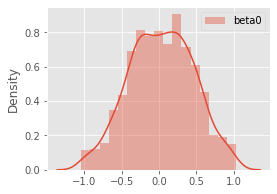

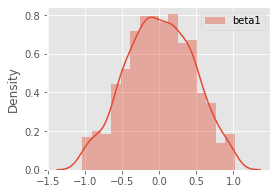

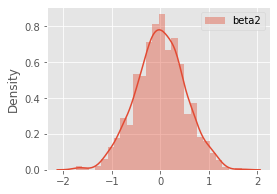

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


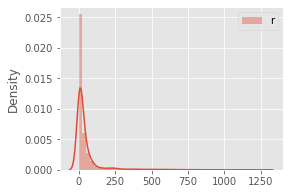

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


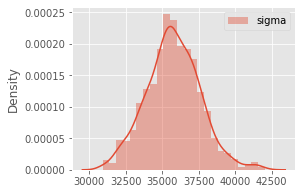

In [184]:
nodes = ["beta", "r", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(3):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

## Get predicted values

In [185]:
y_pred_btc = hmc_samples["y_pred_btc"].mean(axis=0)
print(y_pred_btc)
print(y_obs_btc[T:])

[ -394.60107   -1967.1522     -114.76043      54.478645    548.5119
   897.4049     1280.5713      378.53473    1859.6415     -685.4906
  1901.5105     -253.17404    -719.8293    -1095.4717     -303.10544
  -154.0878    -3339.8003       -7.4514537  1762.4062      701.4125
  -130.28111     177.57762    -368.95813    1956.2787     1030.6238
   297.84476    1863.0627     -246.46555    -896.8543      -52.581924
 -1043.8962      396.3246     1206.8851        4.145094   2708.3835
   180.90738   -1475.8176      528.7249      167.69559    -606.53345
 -1493.684      1546.4263    -1528.7687      698.50366    1114.3837
  -465.33456  ]
[44118.445313 44338.796875 43565.113281 42407.9375   42244.46875
 42197.515625 42586.917969 44575.203125 43961.859375 40538.011719
 40030.976563 40122.15625  38431.378906 37075.28125  38286.027344
 37296.570313 38332.609375 39214.21875  39105.148438 37709.785156
 43193.234375 44354.636719 43924.117188 42451.789063 39137.605469
 39400.585938 38419.984375 38062.039063

## Plot predictions and true values

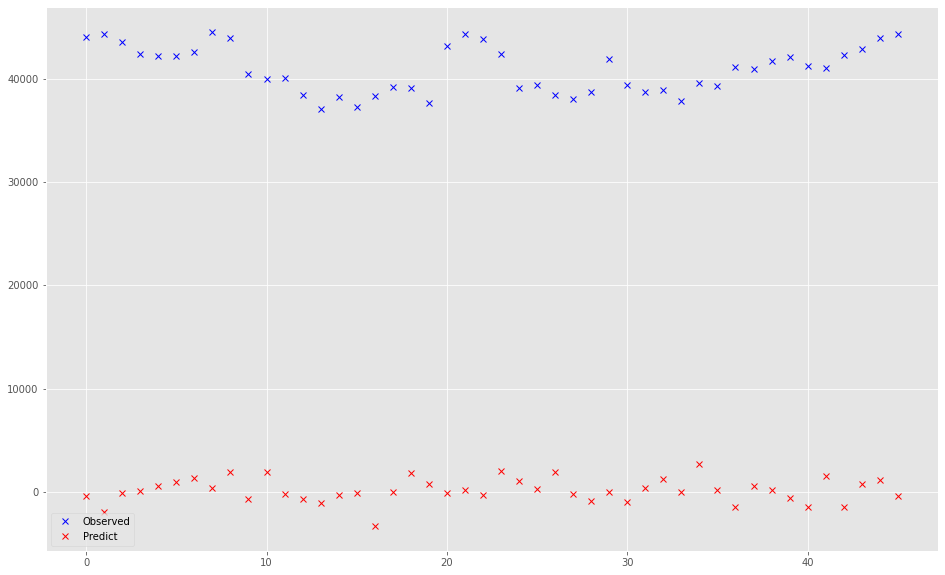

In [186]:
plt.plot(y_obs_btc[T:], "bx")
plt.plot(y_pred_btc,"rx")
plt.legend(["Observed", "Predict"])
plt.show()